# MLflow: Model Tuning

## Importing necessary modules

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

import mlflow
import matplotlib.pyplot as plt
import os

## Data Ingestion

In [3]:
# read the data

train_folder = 'processed_data/train'
validation_folder = 'processed_data/valid'
test_folder = 'processed_data/test'

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=train_folder, transform=preprocess)
valid_data = datasets.ImageFolder(root=validation_folder, transform=preprocess)
test_data = datasets.ImageFolder(root=test_folder, transform=preprocess)

output_dir = 'artifacts/'
os.makedirs(output_dir, exist_ok=True)

In [4]:
num_classes = len(train_data.classes)
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
for image, label in train_loader:
    print(image.size())
    image_size = image.size()[2]
    break

torch.Size([32, 3, 224, 224])


## MLflow experiment

In [6]:
mlflow.set_experiment("Image classification")

2024/05/18 15:36:36 INFO mlflow.tracking.fluent: Experiment with name 'Image classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///media/prithiviraj/AVR/Prithiviraj/Ubuntu/BDL/Project/mlruns/248014270365177687', creation_time=1716026796031, experiment_id='248014270365177687', last_update_time=1716026796031, lifecycle_stage='active', name='Image classification', tags={}>

## Base model definition

In [7]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()

    def forward(self, x):
        x = self.conv1(x)
        if hasattr(self, 'norm1'):
            x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        if hasattr(self, 'norm2'):
            x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [8]:
# training function

def train_model(model, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (batch_idx+1)%10 == 0:
                print(f'Trained batch {batch_idx+1}/{len(train_loader)}')

        loss_history.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}]: loss = {epoch_loss}')

    return loss_history 

# prediction function

def get_prediction(model, train=True):
    model.eval()
    correct_predictions = 0
    total_images = 0

    if train:
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_images += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
    else:
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_images += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

    return (correct_predictions/total_images)*100


# size for convolutional output

def conv2d_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size - kernel_size + 2 * padding) // stride + 1

def maxpool2d_output_size(input_size, kernel_size, stride=None, padding=0):
    if stride is None:
        stride = kernel_size
    return (input_size - kernel_size + 2 * padding) // stride + 1

def get_flatten_size(input_size, layers):
    size = input_size
    for layer in layers:
        if isinstance(layer, nn.Conv2d):
            size = conv2d_output_size(size, layer.kernel_size[0], stride=layer.stride[0], padding=layer.padding[0])
        elif isinstance(layer, nn.MaxPool2d):
            size = maxpool2d_output_size(size, layer.kernel_size, stride=layer.stride, padding=layer.padding)
    return size


# plotting function

def plot_loss(loss_history):
    plt.figure(figsize=(4,3))
    plt.plot(range(1, len(loss_history)+1), loss_history)
    plt.xlabel('Epochs')
    plt.ylabel('Average Epoch Loss')
    plt.show()


## Model 1

In [9]:
# no padding, no normalization, less filters

class CNNModel1(BaseCNN):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        flatten_size = get_flatten_size(image_size, [self.conv1, self.pool1, self.conv2, self.pool2])
        self.fc1 = nn.Linear(32 * flatten_size**2, 128)
        self.fc2 = nn.Linear(128, num_classes)

In [10]:
# model parameters

model_1_params = {
        "conv1": {"in_channels": 3, "out_channels": 16, "kernel_size": 3, "padding": 0},
        "conv2": {"in_channels": 16, "out_channels": 32, "kernel_size": 3, "padding": 0},
        "fc1": {"in_features": 32 * ((image_size // 4) - 1)**2, "out_features": 128},
        "fc2": {"in_features": 128, "out_features": num_classes},
        "normalize": False,
        "learning_rate": 0.001,
        'epochs': 5
    }

In [11]:
# model initialization

model_1 = CNNModel1()
optimizer = optim.Adam(model_1.parameters(), lr=model_1_params['learning_rate'])
criterion = nn.CrossEntropyLoss()
num_epochs = model_1_params['epochs']

print(model_1)

CNNModel1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=93312, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [12]:
parent_id = ''

with mlflow.start_run(run_name='Model Selection') as parent_run:
    parent_id = parent_run.info.run_id
    with mlflow.start_run(run_name='model 1', nested=True):

        # logging the params
        mlflow.log_params(params=model_1_params)

        # model training
        loss_history = train_model(model_1, criterion, optimizer, num_epochs)
        train_accuracy = get_prediction(model_1)
        test_accuracy = get_prediction(model_1, train=False)

        # logging the test metrics
        mlflow.log_metrics({
            "train_accuracy": train_accuracy,
            "train_loss": loss_history[-1],
            "test_accuracy": test_accuracy,
        })

        print(f'Training Accuracy: {round(train_accuracy,2)}%')
        print(f'Testing Accuracy: {round(test_accuracy,2)}%')

        torch.save(model_1.state_dict(), 'artifacts/model_1.pth')

Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [1/5]: loss = 120.49712228775024
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [2/5]: loss = 72.0312180519104
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [3/5]: loss = 51.93554371595383
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [4/5]: loss = 32.5741183757782
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [5/5]: loss = 19.252520605921745
Training Accuracy: 96.65%
Testing Accuracy: 69.4%


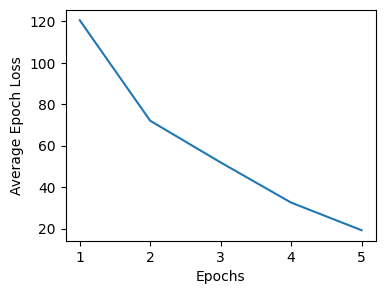

In [13]:
plot_loss(loss_history)

## Model 2

In [14]:
# model with higher number of filters, no normalization, with padding

class CNNModel2(BaseCNN):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        flatten_size = get_flatten_size(image_size, [self.conv1, self.pool1, self.conv2, self.pool2])
        self.fc1 = nn.Linear(64 * flatten_size**2, 128)
        self.fc2 = nn.Linear(128, num_classes)

In [15]:
# model parameters

model_2_params = {
        "conv1": {"in_channels": 3, "out_channels": 32, "kernel_size": 3, "padding": 1},
        "conv2": {"in_channels": 32, "out_channels": 64, "kernel_size": 3, "padding": 1},
        "fc1": {"in_features": 64 * (image_size // 4)**2, "out_features": 128},
        "fc2": {"in_features": 128, "out_features": num_classes},
        "normalize": False,
        "learning_rate": 0.001,
        'epochs': 5
}

In [16]:
# model initialization

model_2 = CNNModel2()
optimizer = optim.Adam(model_2.parameters(), lr=model_2_params['learning_rate'])
criterion = nn.CrossEntropyLoss()
num_epochs = model_2_params['epochs']

print(model_2)

CNNModel2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [17]:
mlflow.end_run()

with mlflow.start_run(run_id=parent_id) as parent_run:
    with mlflow.start_run(run_name='model 2', nested=True):

        # logging the params
        mlflow.log_params(params=model_2_params)

        # model training
        loss_history = train_model(model_2, criterion, optimizer, num_epochs)
        train_accuracy = get_prediction(model_2)
        test_accuracy = get_prediction(model_2, train=False)

        # logging the test metrics
        mlflow.log_metrics({
            "train_accuracy": train_accuracy,
            "train_loss": loss_history[-1],
            "test_accuracy": test_accuracy,
        })

        print(f'Training Accuracy: {round(train_accuracy,2)}%')
        print(f'Testing Accuracy: {round(test_accuracy,2)}%')

        torch.save(model_2.state_dict(), 'artifacts/model_2.pth')

Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [1/5]: loss = 119.35483932495117
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [2/5]: loss = 101.39219760894775
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [3/5]: loss = 88.84731596708298
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [4/5]: loss = 75.26876360177994
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [5/5]: loss = 65.83380037546158
Training Accuracy: 64.65%
Testing Accuracy: 57.2%


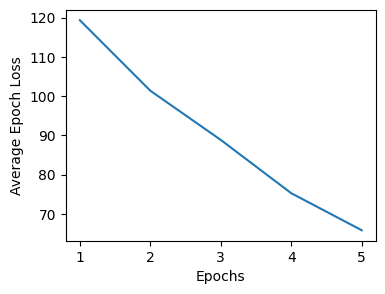

In [18]:
plot_loss(loss_history)

## Model 3

In [19]:
# larger filters, padding and with normalization

class CNNModel3(BaseCNN):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        flatten_size = get_flatten_size(image_size, [self.conv1, self.pool1, self.conv2, self.pool2])
        self.fc1 = nn.Linear(64 * flatten_size**2, 128)
        self.fc2 = nn.Linear(128, num_classes)

In [20]:
# model parameters

model_3_params = {
        "conv1": {"in_channels": 3, "out_channels": 32, "kernel_size": 5, "padding": 2},
        "conv2": {"in_channels": 32, "out_channels": 64, "kernel_size": 5, "padding": 2},
        "fc1": {"in_features": 64 * (image_size // 4)**2, "out_features": 128},
        "fc2": {"in_features": 128, "out_features": num_classes},
        "normalize": True,
        "normalize": False,
        "learning_rate": 0.001,
        'epochs': 5
    }

In [21]:
# model initialization

model_3 = CNNModel3()
optimizer = optim.Adam(model_3.parameters(), lr=model_3_params['learning_rate'])
criterion = nn.CrossEntropyLoss()
num_epochs = model_3_params['epochs']

print(model_3)

CNNModel3(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [22]:
mlflow.end_run()

with mlflow.start_run(run_id=parent_id) as parent_run:
    with mlflow.start_run(run_name='model 3', nested=True):

        # logging the params
        mlflow.log_params(params=model_3_params)

        # model training
        loss_history = train_model(model_3, criterion, optimizer, num_epochs)
        train_accuracy = get_prediction(model_3)
        test_accuracy = get_prediction(model_3, train=False)

        # logging the test metrics
        mlflow.log_metrics({
            "train_accuracy": train_accuracy,
            "train_loss": loss_history[-1],
            "test_accuracy": test_accuracy,
        })

        print(f'Training Accuracy: {round(train_accuracy,2)}%')
        print(f'Testing Accuracy: {round(test_accuracy,2)}%')

        torch.save(model_3.state_dict(), 'artifacts/model_3.pth')

Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [1/5]: loss = 564.6628728508949
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [2/5]: loss = 111.67310613393784
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [3/5]: loss = 92.65309917926788
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [4/5]: loss = 47.39246082305908
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [5/5]: loss = 35.82050420343876
Training Accuracy: 86.3%
Testing Accuracy: 68.6%


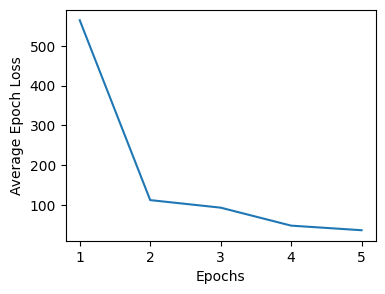

In [24]:
plot_loss(loss_history)

## Model 4

In [25]:
# model with smaller filter, no padding and with normalization

class CNNModel4(BaseCNN):
    def __init__(self):
        super(CNNModel4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        flatten_size = get_flatten_size(image_size, [self.conv1, self.pool1, self.conv2, self.pool2])
        self.fc1 = nn.Linear(64 * flatten_size**2, 128)
        self.fc2 = nn.Linear(128, num_classes)

In [26]:
# model parameters

model_4_params = {
        "conv1": {"in_channels": 3, "out_channels": 32, "kernel_size": 3, "padding": 0},
        "conv2": {"in_channels": 32, "out_channels": 64, "kernel_size": 3, "padding": 0},
        "fc1": {"in_features": 64 * ((image_size // 4) - 1)**2, "out_features": 128},
        "fc2": {"in_features": 128, "out_features": num_classes},
        "normalize": True,
        "learning_rate": 0.01,
        'epochs': 1
    }

In [27]:
# model initialization

model_4 = CNNModel4()
optimizer = optim.Adam(model_4.parameters(), lr=model_4_params['learning_rate'])
criterion = nn.CrossEntropyLoss()
num_epochs = model_4_params['epochs']

print(model_4)

CNNModel4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [28]:
mlflow.end_run()

with mlflow.start_run(run_id=parent_id) as parent_run:
    with mlflow.start_run(run_name='model 4', nested=True):

        # logging the params
        mlflow.log_params(params=model_4_params)

        # model training
        loss_history = train_model(model_4, criterion, optimizer, num_epochs)
        train_accuracy = get_prediction(model_4)
        test_accuracy = get_prediction(model_4, train=False)

        # logging the test metrics
        mlflow.log_metrics({
            "train_accuracy": train_accuracy,
            "train_loss": loss_history[-1],
            "test_accuracy": test_accuracy,
        })

        print(f'Training Accuracy: {round(train_accuracy,2)}%')
        print(f'Testing Accuracy: {round(test_accuracy,2)}%')

        torch.save(model_4.state_dict(), 'artifacts/model_4.pth')

Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [1/1]: loss = 2698.4847836494446
Training Accuracy: 20.0%
Testing Accuracy: 20.0%


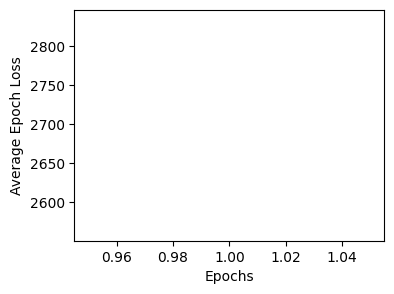

In [29]:
plot_loss(loss_history)

## Model 5

In [30]:
# model with no padding, no normalization, smaller filters and less filters

class CNNModel5(BaseCNN):
    def __init__(self):
        super(CNNModel5, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        flatten_size = get_flatten_size(image_size, [self.conv1, self.pool1, self.conv2, self.pool2])
        self.fc1 = nn.Linear(32 * flatten_size**2, 128)
        self.fc2 = nn.Linear(128, num_classes)

In [31]:
# model parameters

model_5_params = {
        "conv1": {"in_channels": 3, "out_channels": 16, "kernel_size": 5, "padding": 0},
        "conv2": {"in_channels": 16, "out_channels": 32, "kernel_size": 5, "padding": 0},
        "fc1": {"in_features": 32 * image_size**2, "out_features": 128},
        "fc2": {"in_features": 128, "out_features": num_classes},
        "normalize": False,
        "learning_rate": 0.1,
        'epochs': 3
    }

In [32]:
# model initialization

model_5 = CNNModel5()
optimizer = optim.Adam(model_5.parameters(), lr=model_5_params['learning_rate'])
criterion = nn.CrossEntropyLoss()
num_epochs = model_5_params['epochs']

print(model_5)

CNNModel5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [33]:
mlflow.end_run()

with mlflow.start_run(run_id=parent_id) as parent_run:
    with mlflow.start_run(run_name='model 5', nested=True):

        # logging the params
        mlflow.log_params(params=model_5_params)

        # model training
        loss_history = train_model(model_5, criterion, optimizer, num_epochs)
        train_accuracy = get_prediction(model_5)
        test_accuracy = get_prediction(model_5, train=False)

        # logging the test metrics
        mlflow.log_metrics({
            "train_accuracy": train_accuracy,
            "train_loss": loss_history[-1],
            "test_accuracy": test_accuracy,
        })

        print(f'Training Accuracy: {round(train_accuracy,2)}%')
        print(f'Testing Accuracy: {round(test_accuracy,2)}%')

        torch.save(model_5.state_dict(), 'artifacts/model_5.pth')

Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [1/3]: loss = 129298.98551821709
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [2/3]: loss = 101.8001275062561
Trained batch 10/63
Trained batch 20/63
Trained batch 30/63
Trained batch 40/63
Trained batch 50/63
Trained batch 60/63
Epoch [3/3]: loss = 101.82072305679321
Training Accuracy: 20.0%
Testing Accuracy: 20.0%


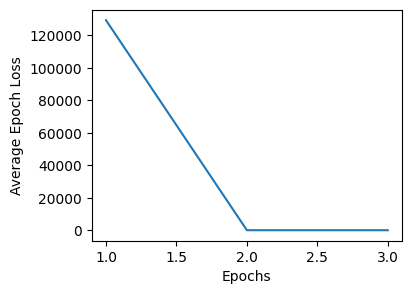

In [35]:
plot_loss(loss_history)